In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [27]:
class Cell:
    def __init__(self, model_type, params): # where model_type is a string and params is a dictionary with the parameters
        self.model_type = model_type
        self.params = params # params you might need [vmax, km, ki (haldane), n (moser), lp ...]

    def growth_rate(self, substrate_conc):
        if self.model_type == 'monod':
            return self.monod(substrate_conc)
        elif self.model_type == 'haldane':
            return self.haldane(substrate_conc)
        elif self.model_type == 'contois':
            return self.contois(substrate_conc)
        elif self.model_type == 'moser':
            return self.moser(substrate_conc)
        elif self.model_type == 'tessier':
            return self.tessier(substrate_conc)
        elif self.model_type == 'luedeking_piret':
            return self.luedeking_piret(substrate_conc)
        
        


    def monod(self, s):
        vmax = self.params['vmax']
        km = self.params['km']
        return vmax * s / (km + s)

    def haldane(self, s):
        vmax = self.params['vmax']
        km = self.params['km']
        ki = self.params['ki']
        return vmax * s / (km + s + (s**2 / ki))

    def contois(self, s):
        vmax = self.params['vmax']
        km = self.params['km']
        return vmax * s / (km * x + s)

    def moser(self, s):
        vmax = self.params['vmax']
        km = self.params['km']
        n = self.params['n']
        return vmax * (s**n) / (km + (s**n))

    def tessier(self, s):
        umax = self.params['umax']
        k = self.params['km']
        return umax * (1 - np.exp(-s /km))

    def luedeking_piret(self, s):
        pass



class Tank:
    def __init__(self, initial_biomass, initial_substrate, cell, volume, initial_product = 0):
        self.biomass = initial_biomass
        self.substrate = initial_substrate
        self.product = initial_product
        self.cell = cell
        self.volume = volume

## reaction_rates method

    def reaction_rates(self):
        # want to return the ODEs needed
        mu = self.cell.growth_rate(self.substrate) # takes equation from whatever model is chosen
        m = self.cell.params.get("m", 0.1)
        dxdt = mu * self.biomass - (m * self.biomass) # mu * x - (m * x)
        dsdt = 1 / self.cell.params.get("y_coeff", 1) * (mu * self.biomass) 
        if self.cell.model_type == 'Luedeking-Piret':
            dpdt = self.cell.product_formation_rate(self.biomass, self.substrate)
        else:
            dpdt = 0
        return [dxdt, dsdt, dpdt]



def simulate_bioreactor(tank, t_span, time_step): #tank model, time span e.g. (0, 100) and time step for evaluation.
    def model(t, y):
        tank.biomass, tank.substrate, tank.product = y # initial conditions and parameters in ODE as y
        return tank.reaction_rates() # returns [dxdt, dsdt, dpdt]

    initial_conditions = [tank.biomass, tank.substrate, tank.product]
    solution = solve_ivp(model, t_span, initial_conditions, method='RK45', t_eval=np.arange(t_span[0], t_span[1], time_step))
    #solve_ivp(haldane, t_span, [X0, S0], args=(vmax, km, ki, y_coeff, m), t_eval=t_eval) example
    return solution

In [8]:
## testing out the cell tank interaction
cell_test = Cell("monod", {"vmax" : 0.8, "km" : 1})
tank_test = Tank(1, 10, cell_test, 1000)



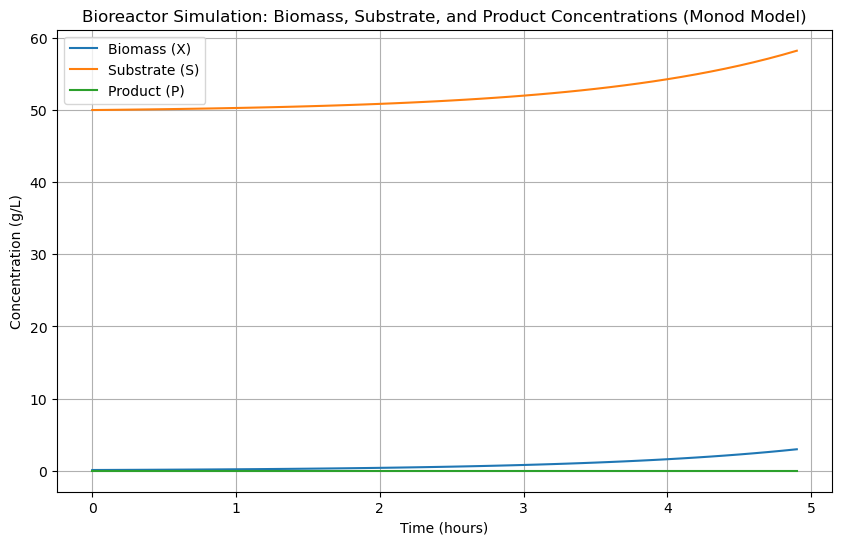

In [28]:
# Define initial conditions and parameters
initial_biomass = 0.1   # g/L
initial_substrate = 50.0  # g/L
initial_product = 0.0   # g/L
volume = 1.0            # L (assuming a 1L bioreactor)

# Define Cell parameters for Monod model
params_monod = {
    'vmax': 0.8,   # 1/h
    'km': 0.5,      # g/L
    'y_coeff' : 0.4
}

# Create Cell and Tank instances for Monod model
cell_monod = Cell('monod', params_monod)
tank_monod = Tank(initial_biomass, initial_substrate, cell_monod, volume, initial_product)
# (self, initial_biomass, initial_substrate, cell, volume, initial_product = 0):

# Simulate the bioreactor for Monod model
t_span = (0, 5)  # hours
time_step = 0.1  # hours

solution_monod = simulate_bioreactor(tank_monod, t_span, time_step)

# Plot the results for Monod model
plt.figure(figsize=(10, 6))
plt.plot(solution_monod.t, solution_monod.y[0], label='Biomass (X)')
plt.plot(solution_monod.t, solution_monod.y[1], label='Substrate (S)')
plt.plot(solution_monod.t, solution_monod.y[2], label='Product (P)')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration (g/L)')
plt.title('Bioreactor Simulation: Biomass, Substrate, and Product Concentrations (Monod Model)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
### this shouldn't be happening ^^